In [30]:
import pandas as pd
import numpy as np
import tensorflow
import math
import matplotlib.pyplot as plt
import time
import json

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from urllib.request import urlopen
from PIL import Image
from sklearn.linear_model import Ridge
from sklearn.svm import LinearSVR
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


In [2]:
items = pd.read_csv("/kaggle/input/items-user-feature-40u/items.csv")
ratings = pd.read_csv("/kaggle/input/items-user-feature-40u/ratings.csv")
f_img = np.load("/kaggle/input/items-user-feature-40u/imgs_features.npy")
images = np.load("/kaggle/input/items-user-feature-40u/images.npy")

In [3]:
user_list = ratings["user"].unique()
item_list = items["asin"].unique()
n_users = len(user_list)
n_items = len(item_list)

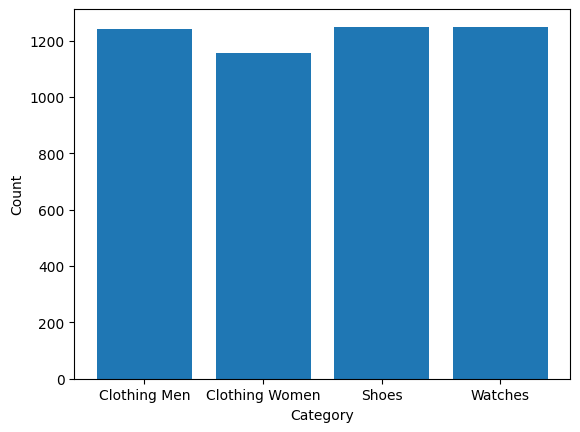

In [6]:
counts = items.groupby('categories')['asin'].count()
plt.bar(counts.index, counts.values)
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

In [7]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(ratings, test_size = 0.4, random_state = 42)

In [8]:
rate_train = train_data.values
rate_test = test_data.values
rate = ratings.values

In [11]:
def get_index_from_asin(ids):
    df_indices = items.loc[items['asin'].isin(ids)]
    if not df_indices.empty:
        id_list = ids.tolist()
    return df_indices.index

In [12]:
def get_items_rated_by_user(rate_matrix, user_id):
    y = rate_matrix[:, 0] # all users
    ids = np.where(y == user_id)[0] # item indices rated by user_id
    if len(ids) == 0:
        return (), ()
    else:
        item_ids = rate_matrix[ids,  1]
        scores = rate_matrix[ids, 2]
        return (item_ids, scores)

In [13]:
def evaluate(Yhat, rates, W, b):
    se = 0
    cnt = 0
    for n in range(n_users):
        ids, scores_truth = get_items_rated_by_user(rates, user_list[n])
        id_ = get_index_from_asin(ids).to_numpy()
        scores_pred = Yhat[id_, n]
        e = scores_truth - scores_pred 
        se += (e*e).sum(axis = 0)
        cnt += e.size 
    return np.sqrt(se/cnt)

In [14]:
d = f_img.shape[1]
W = np.zeros((d, n_users))
b = np.zeros((1, n_users))

start_time = time.time()

for n in range(n_users):
    ids, scores = get_items_rated_by_user(rate_train, user_list[n])
    clf = Ridge(alpha=0.01, fit_intercept=True)
    Xhat = f_img[np.array(get_index_from_asin(ids))]
    
    clf.fit(Xhat, scores) 
    W[:, n] = clf.coef_
    b[0, n] = clf.intercept_
    
Yhat = f_img.dot(W) + b

end_time = time.time()
total_time = end_time - start_time

print('Ridge')
print('RMSE for training:', evaluate(Yhat, rate_train, W, b))
print('RMSE for test    :', evaluate(Yhat, rate_test, W, b))
print('Time:', round(total_time), 's')

Ridge
RMSE for training: 1.2506128732514286
RMSE for test    : 1.6488379210544668
Time: 3 s


In [15]:
d = f_img.shape[1] # data dimension
W = np.zeros((d, n_users))
b = np.zeros((1, n_users))

start_time = time.time()

for n in range(n_users):
    ids, scores = get_items_rated_by_user(rate_train, user_list[n])
    clf = LinearSVR(C=1.0, epsilon=0.6, max_iter=5000)
    Xhat = f_img[np.array(get_index_from_asin(ids))]

    clf.fit(Xhat, scores) 
    W[:, n] = clf.coef_
    b[0, n] = clf.intercept_

Yhat_SVM = f_img.dot(W) + b

end_time = time.time()
total_time = end_time - start_time

print('SVM')
print('RMSE for training:', evaluate(Yhat_SVM, rate_train, W, b))
print('RMSE for test    :', evaluate(Yhat_SVM, rate_test, W, b))
print('Time:', round(total_time), 's')

SVM
RMSE for training: 1.3386995060563143
RMSE for test    : 1.588653536239346
Time: 3 s


In [16]:
d = f_img.shape[1] # số lượng đặc trưng
W = np.zeros((d, n_users))
b = np.zeros((1, n_users))

start_time = time.time()

for n in range(n_users):
    ids, scores = get_items_rated_by_user(rate_train, user_list[n])
    clf = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    Xhat = f_img[np.array(get_index_from_asin(ids))]
    
    clf.fit(Xhat, scores) 
    W[:, n] = clf.feature_importances_
    b[0, n] = np.mean(scores)
    
Yhat_GB = f_img.dot(W) + b

end_time = time.time()
total_time = end_time - start_time

print('GradientBoosting')
print('RMSE for training:', evaluate(Yhat_GB, rate_train, W, b))
print('RMSE for test    :', evaluate(Yhat_GB, rate_test, W, b))
print('Time:', round(total_time), 's')

GradientBoosting
RMSE for training: 1.458445628698509
RMSE for test    : 1.5260918203452096
Time: 56 s


In [17]:
d = f_img.shape[1] # số lượng đặc trưng
W = np.zeros((d, n_users))
b = np.zeros((1, n_users))

start_time = time.time()

for n in range(n_users):
    ids, scores = get_items_rated_by_user(rate_train, user_list[n])
    clf = XGBRegressor(n_estimators=30, learning_rate=0.1, random_state=42, alpha=1, reg_lambda=1)
    Xhat = f_img[np.array(get_index_from_asin(ids))]
    
    clf.fit(Xhat, scores) 
    W[:, n] = clf.feature_importances_
    b[0, n] = np.mean(scores)
    
Yhat_XGB = f_img.dot(W) + b

end_time = time.time()
total_time = end_time - start_time

print('XGBoost')
print('RMSE for training:', evaluate(Yhat_XGB, rate_train, W, b))
print('RMSE for test    :', evaluate(Yhat_XGB, rate_test, W, b))
print('Time:', round(total_time), 's')

XGBoost
RMSE for training: 1.4588634267271599
RMSE for test    : 1.5231017989520594
Time: 15 s


In [18]:
d = f_img.shape[1] # số lượng đặc trưng
W = np.zeros((d, n_users))
b = np.zeros((1, n_users))

start_time = time.time()

for n in range(n_users):
    ids, scores = get_items_rated_by_user(rate_train, user_list[n])
    clf = ExtraTreeRegressor(max_leaf_nodes = 100, random_state=42)
    Xhat = f_img[np.array(get_index_from_asin(ids))]
    
    clf.fit(Xhat, scores) 
    W[:, n] = clf.feature_importances_
    b[0, n] = np.mean(scores)
    
Yhat_ET = f_img.dot(W) + b

end_time = time.time()
total_time = end_time - start_time

print('ExtraTree')
print('RMSE for training:', evaluate(Yhat_ET, rate_train, W, b))
print('RMSE for test    :', evaluate(Yhat_ET, rate_test, W, b))
print('Time:', round(total_time), 's')

ExtraTree
RMSE for training: 1.4616593743473545
RMSE for test    : 1.5296682060777513
Time: 4 s


In [19]:
d = f_img.shape[1] # số lượng đặc trưng
W = np.zeros((d, n_users))
b = np.zeros((1, n_users))

start_time = time.time()

for n in range(n_users):
    ids, scores = get_items_rated_by_user(rate_train, user_list[n])
    clf = DecisionTreeRegressor(random_state=42)
    Xhat = f_img[np.array(get_index_from_asin(ids))]
    
    clf.fit(Xhat, scores) 
    W[:, n] = clf.feature_importances_
    b[0, n] = np.mean(scores)
    
Yhat_DT = f_img.dot(W) + b

end_time = time.time()
total_time = end_time - start_time

print('DecisionTree')
print('RMSE for training:', evaluate(Yhat_DT, rate_train, W, b))
print('RMSE for test    :', evaluate(Yhat_DT, rate_test, W, b))
print('Time:', round(total_time), 's')

DecisionTree
RMSE for training: 1.463571845806628
RMSE for test    : 1.5322441953186232
Time: 3 s


In [20]:
d = f_img.shape[1] # số lượng đặc trưng
W = np.zeros((d, n_users))
b = np.zeros((1, n_users))

start_time = time.time()

for n in range(n_users):
    ids, scores = get_items_rated_by_user(rate_train, user_list[n])
    clf = RandomForestRegressor(n_estimators=50, random_state=42)
    Xhat = f_img[np.array(get_index_from_asin(ids))]
    
    clf.fit(Xhat, scores) 
    W[:, n] = clf.feature_importances_
    b[0, n] = np.mean(scores)
    
Yhat_RF = f_img.dot(W) + b 

end_time = time.time()
total_time = end_time - start_time

print('RandomForest')
print('RMSE for training:', evaluate(Yhat_RF, rate_train, W, b))
print('RMSE for test    :', evaluate(Yhat_RF, rate_test, W, b))
print('Time:', round(total_time), 's')

RandomForest
RMSE for training: 1.4550794567774121
RMSE for test    : 1.521774244815955
Time: 106 s


In [24]:
def recommend_for_user(n, k, df, Yhat, user_list, rate_user):
    rated_items, score = get_items_rated_by_user(rate_user, user_list[n])
    id_rated_items = get_index_from_asin(rated_items)
    num_images = k
    num_rows = math.ceil(num_images / 5)
    num_cols = 5
    
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 3*num_rows))
    count = 0
    for i in np.argsort(-Yhat[n]):
        if i not in id_rated_items:
            row_idx = count // num_cols
            col_idx = count % num_cols

            img_url = df.loc[i, "imUrl"]
            response = urlopen(img_url)
            img = Image.open(response)

            axs[row_idx, col_idx].imshow(img)
            axs[row_idx, col_idx].axis('off')
            axs[row_idx, col_idx].set_title(f"Predict score {Yhat[n][i]:.2f}")
            count += 1
        if count == k:
            break

    fig.suptitle(f"Recommendation for user {user_list[n]}")
    plt.show()

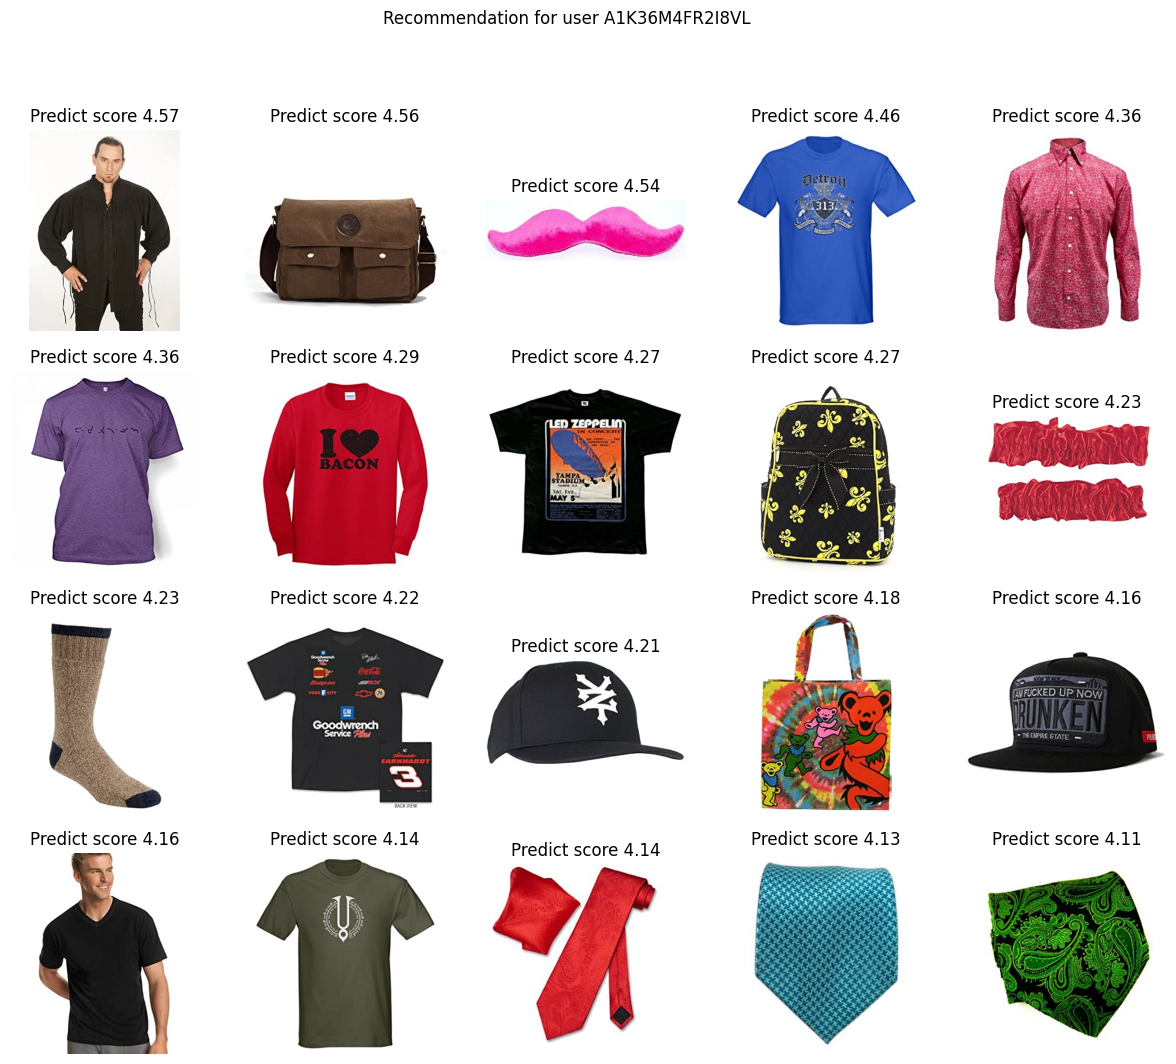

In [40]:
recommend_for_user(6, 20, items, Yhat_XGB, user_list, rate)

In [32]:
def show_rated_items(user_id, ratings_df, items_df):
    rated_items = ratings_df[ratings_df["user"] == user_id]
    rated_items = pd.merge(rated_items, items_df[["asin", "imUrl", "title", "price"]], on="asin", how="left")
    rated_items = rated_items.sort_values(by="rating", ascending=False).reset_index(drop=True)
    num_images = len(rated_items)
    num_rows = math.ceil(num_images / 5)
    num_cols = 5

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 3*num_rows))

    count = 0
    for i in range(num_rows):
        for j in range(num_cols):
            idx = i * num_cols + j
            if idx >= num_images:
                break
            img_url = rated_items.loc[idx, "imUrl"]
            response = urlopen(img_url)
            img = Image.open(response)

            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            axs[i, j].set_title(f"Rating: {rated_items.loc[idx, 'rating']}")

            count += 1

    fig.suptitle(f"Rated items by user {user_id}")
    plt.show()

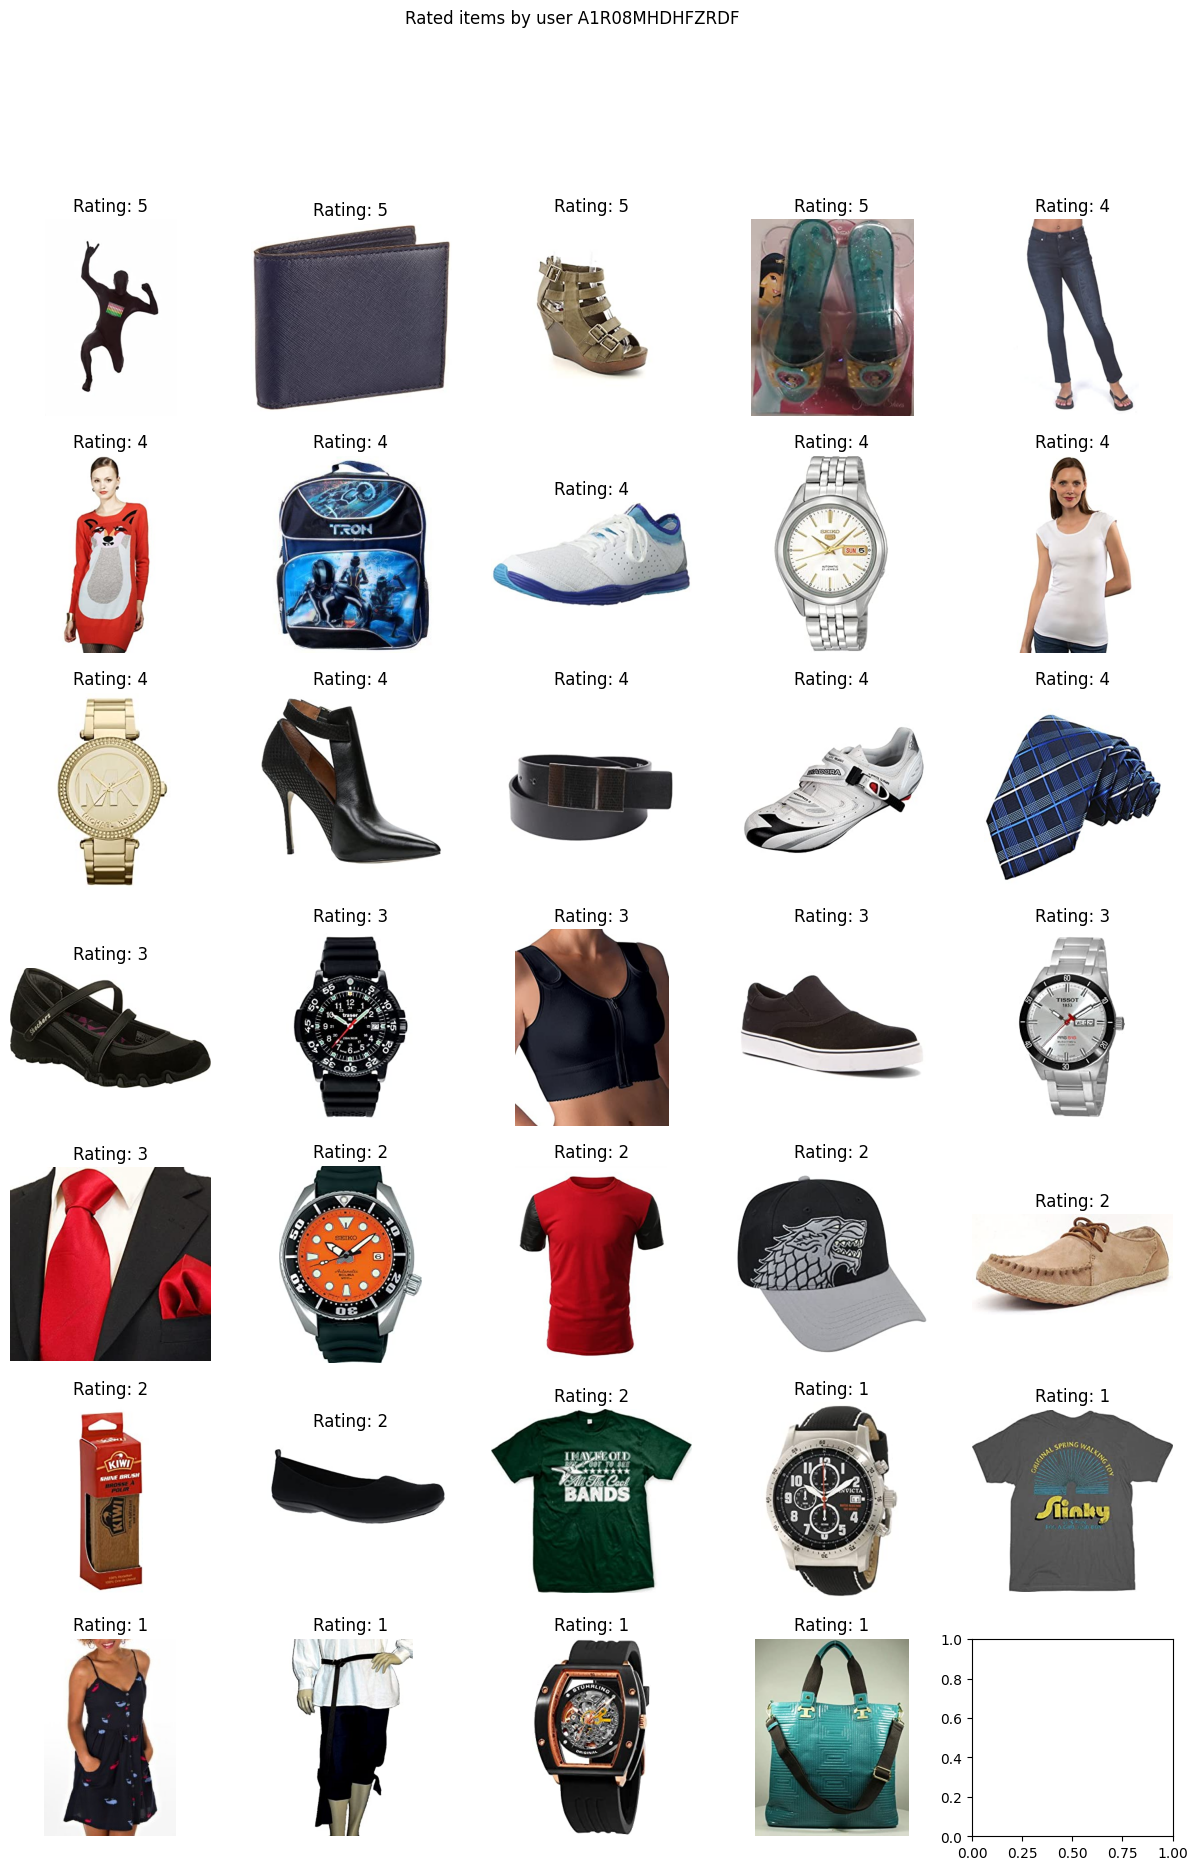

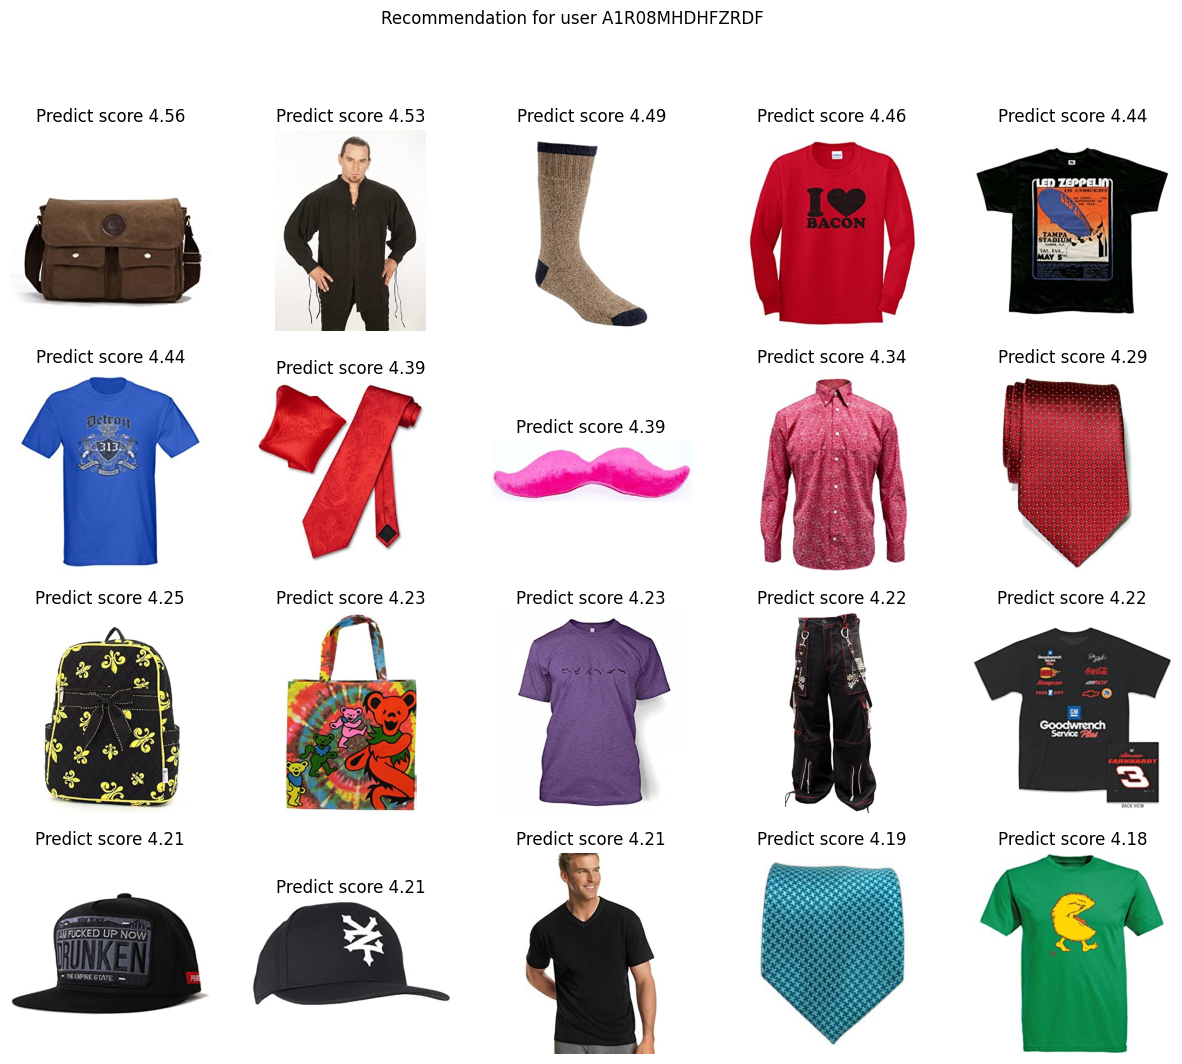

In [44]:
n = 1000
show_rated_items(user_list[n], ratings, items)
recommend_for_user(n, 20, items, Yhat_XGB, user_list, rate)